# Tarea 2 

**Curso SP6527 Economía Computacional**

Estudiante:  Alexander Robles Vargas, carné B76394

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Pregunta 1
Encuentre el valor máximo de la función
\begin{equation*}
f(x,y) = 2xy +1.5y-1.25x^2-2y^2
\end{equation*}

### 1a
Encontrando las condiciones de primer orden y resolviendo el sistema resultante con `numpy.linalg.solve`.


\begin{equation*}
\frac{\partial f}{\partial x} = 2y -1.25\cdot 2 x =0
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial y} = 2x + 1.5 - 4y =0
\end{equation*}


In [56]:
A = np.array([[-1.25*2,2],
              [2,-4]])

b = np.array([0,-1.5])

x, y = np.linalg.solve(A,b)
print(f'{x=},  {y=}')

x=0.5,  y=0.625


### 1b
Sin las condiciones de primer orden, usando para ello la clase `OP` de compecon, a partir del valor inicial $x=y=1$:

- Primero, utilizando los parámetros predeterminados del método `.qnewton` de `OP`.

In [57]:
from compecon import OP

def f(z):
    return 2*z[0]*z[1] + 1.5*z[1] -1.25*z[0]**2 - 2*z[1]**2

z0 = [1,1]

problema = OP(f)
problema.qnewton(z0)    

array([0.5  , 0.625])

- Segundo, compare en un solo gráfico las sendas de convergencia de los algoritmos `“steepest”`, `"bfgs"`, y `"dfp"`. **Pista**: cuando aplique el método `.qnewton` utilice la opción `SearchMeth` para escoger el algoritmo, y la opción `all_x` para guardar todas las iteraciones. Para ver los resultados de las iteraciones, vea la propiedad `x_sequence` del objeto de `OP`.

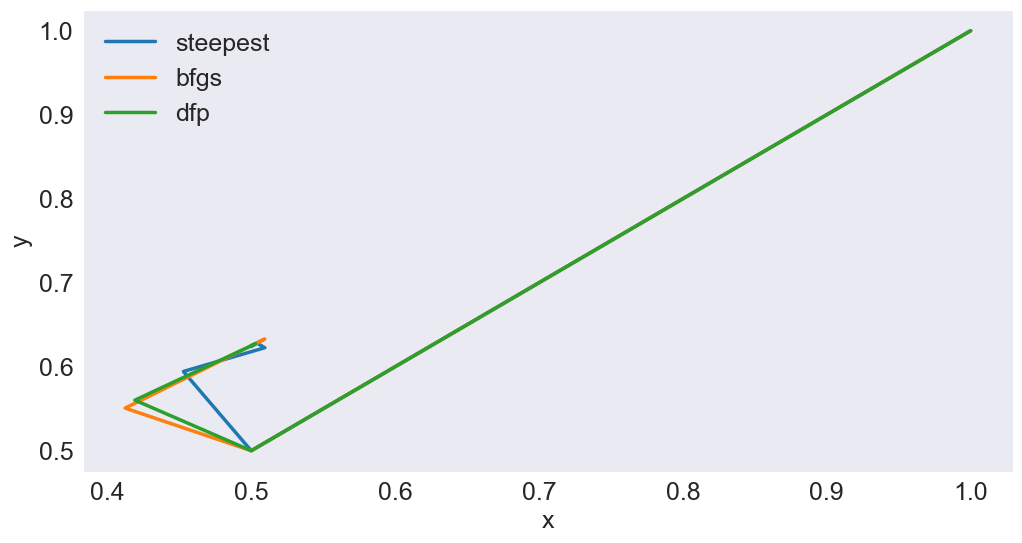

In [58]:
metodos = ['steepest', 'bfgs', 'dfp']
resultados = dict()

fig, ax = plt.subplots()

for metodo in metodos:
    z = problema.qnewton(SearchMeth=metodo, all_x = True)
    resultados['x'], resultados['y'] = problema.x_sequence[0], problema.x_sequence[1]
    ax.plot(resultados['x'], resultados['y'], label=metodo)

ax.set(xlabel='x', ylabel='y')
ax.legend()


## Pregunta 2

Considere este modelo econométrico tomado de **Wooldridge (2012)** Introductory Econometrics: A Modern Approach}.

Sea **inlf** (``in the labor force'') una variable binaria que indica la participación en la fuerza laboral de una mujer casada durante 1975: $inlf = 1$ si la mujer reporta haber trabajado por un salario fuera de su hogar en algún momento de ese año, y 0 de lo contrario.

Asumimos que la participación en la fuerza laboral depende de otras fuentes de ingreso, entre ellos los ingresos del esposo (**nwifeinc**, medidos en miles de dólares), años de educación (**educ**), años de experiencia laboral (**exper**), edad **age**, número de hijos menores de seis años de edad (**kidslt6**), y número de hijos entre 6 y 18 años de edad (**kidsge6**). Usando los datos en MROZ.DTA, disponibles en http://fmwww.bc.edu/ec-p/data/wooldridge/mroz.dta, estime los siguientes modelos:

- un modelo de probabilidad lineal,
- un modelo logit,
- un modelo probit.

\begin{equation*}
\text{inlf} = f(\text{nwifeinc}, \text{educ}, \text{exper},\text{exper}^2,\text{age},\text{kidslt6},\text{kidsge6})
\end{equation*}

En la muestra, 428 de las 753 mujeres reportaron participar  en la fuerza laboral en algún momento durante 1975.

Su código debe producir una tabla con los coeficientes estimados.

### 2a
Lea los datos en un “dataframe” de pandas. Pista: use `pandas.read_stata`.

In [59]:
datos = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/mroz.dta') #Pista: no hace falta descargar el archivo previamente

### 2b
Agrege dos columnas a su “dataframe”: 

- (1) una columna de unos (llámelo `"intercept"`) y 
- (2) el cuadrado de la experiencia (llámelo `"exper^2"`).

In [60]:
datos['intercept'] = 1
datos["exper^2"] = datos["exper"]**2



### 2c
Defina las matrices de diseño `X` y `y`. Asegúrese de seleccionar las columnas en el orden mostrado en la tabla de la pregunta.

In [61]:
regresores = ['intercept', 'nwifeinc', 'educ', 'exper', 'exper^2', 'age', 'kidslt6', 'kidsge6']
X = datos[regresores]
y = datos['inlf']


### 2d
Defina los (**negativos**) de las funciones de verosimilitud requeridas para calcular los estimadores logit y probit. Usaremos la función `scipy.optimize.minimize` para calcular los estimadores de máxima verosimilitud.

In [62]:
from scipy.stats import norm, logistic
from scipy.optimize import minimize

def logL_logit(β):
    L_logit= (y*np.log(logistic.cdf(X @ β)) + (1-y)*np.log(1-logistic.cdf(X @ β))).sum()
    return -L_logit
    
def logL_probit(β):
    L_probit = (y*np.log(norm.cdf(X @ β)) + (1-y)*np.log(1-norm.cdf(X @ β))).sum()
    return -L_probit


### 2e
Calcule los tres estimadores y guárdelos en un “dataframe” de pandas. Imprima su resultado. Pista: Recuerde que el estimador OLS es $(X'X)^{-1}X'y$

In [65]:
β_ols = np.linalg.solve(np.dot(X.transpose(), X), np.dot(X.transpose(), y))
β_logit = minimize(logL_logit, β_ols, method="Nelder-Mead")['x'] # lea la documentación de minimize para entender porqué ['x'] al final
β_probit = minimize(logL_probit, β_ols, method="Nelder-Mead")['x']
β_hat = pd.DataFrame({
    'linear': β_ols,
    'logit': β_logit,
    'probit': β_probit},
    index=regresores)

β_hat.style.format(precision=3)

,linear,logit,probit
intercept,0.586,0.425,0.270
nwifeinc,-0.003,-0.021,-0.012
educ,0.038,0.221,0.131
exper,0.039,0.206,0.123
exper^2,-0.001,-0.003,-0.002
age,-0.016,-0.088,-0.053
kidslt6,-0.262,-1.443,-0.868
kidsge6,0.013,0.060,0.036


## Pregunta 3
Considere la integral
\begin{equation*}
\int_{-1}^{1}2-x^2 \mathtt{d}x
\end{equation*}

### 3a
Obtenga su valor utilizando cálculo integral.

\begin{equation*}
\Rightarrow \int_{-1}^{1} 2 \mathtt{d}x - \int_{-1}^{1} x^2 \mathtt{d}x = \left[ 2x \right] _{-1}^{1} - \left[ \frac{x^3}{3}\right] _{-1}^{1} = \frac{10}{3}
\end{equation*}


### 3b 
Aproxime su valor por medio de la regla del trapezoide, utilizando 5 nodos.

In [66]:
from compecon import qnwtrap

f = lambda x: 2-x**2
x, w = qnwtrap(5,-1,1)
area = w.dot(f(x))
print(area)

3.25


## Pregunta 4

$\text{\textbf{Falso}}$: debido a que existen errores de redondeo, pues los números en una computadora se expresan mediante bits, los valores de $h$ no se pueden hacer tan pequeños como se quiera. En la práctica lo que sucede es que: la aproximación de la derivada comienza a converger a la derivada real cuando $h$ se hace pequeño; pero llega a un punto donde $h$ es tan pequeño que los errores de redondeo causan que la aproximación comienza a perder exactitud. 

## Pregunta 5

sea:

\begin{align*}
f(x+h^2) &= f(x)+f'(x)h^2 +O((h^2)^2)\\
f(x+h^2)-f(x) &= f'(x)h^2 +O(h^4)\\
\frac{f(x+h^2)-f(x)}{h^2} + O(h^2) &= f'(x)
\end{align*}

## Pregunta 6
La demanda por un bien está dada por $q=2p^{-0.5}$. El precio del bien cae de 4 a 1. Calcule el cambio en el excedente del consumidor

### (a)
analíticamente, usando cálculo;

\begin{align*}
\Delta CS &= CS(1)-CS(4) \\
    	  &=\int^{+\infty}_{1} 2p^{-0.5} \mathtt{d}p - \int^{+\infty} _{4} 2p^{-0.5} \mathtt{d}p \\
		  &= \int^{4} _{1} 2p^{-0.5} \mathtt{d}p \\
		  &= \left[4 p^{0.5} \right]^{4} _{1} \\
		  &= 4
\end{align*}

### (b)
numéricamente, usando  la regla del trapezoide con 5 nodos;

In [113]:
from sympy import Q


q = lambda p: 2*p**(-0.5)

a, b = 1, 4  # limites de integración

p, w = qnwtrap(5,a,b)

area = w.dot(q(p))
print(area)

4.039627011416039


### (c)
numéricamente, usando  la regla de Simpson con 5 nodos;

In [114]:
from compecon import qnwsimp

p, w = qnwsimp(5,a,b)

area = w.dot(q(p))
print(area)

4.003713816521044


### (d)
numéricamente, usando  la regla de Gauss-Legendre con 5 nodos;

In [115]:
from compecon import qnwlege

p, w = qnwlege(5,a,b)

area = w.dot(q(p))
print(area)

3.9999831601664724



### (e)
numéricamente, usando  una secuencia de Weyl de 100 nodos equiespaciados.



In [122]:
from compecon import qnwequi

p, w = qnwequi(100,a,b, kind='W')

area = w.dot(q(p))
print(area)

4.003976665125693
